In [1]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable

# load the background and blackbox dataset

In [49]:
f_PureBkg = pd.read_hdf("../../MassRatio_pureBkg.h5")
dt_PureBkg = f_PureBkg.values

In [50]:
f_BB = pd.read_hdf("../../MassRatio_BB1.h5")
dt_BB = f_BB.values

In [51]:
f_BB.head()

,Mjj,Mj1,j1 tau21,j1 tau32,j1 tau43,j1 sqrt(tau^2_1)/tau^1_1,j1 n_trk,j1 pT1,j1 M_trim,j1 M_prun,...,j2 tau43,j2 sqrt(tau^2_1)/tau^1_1,j2 n_trk,j2 pT1,j2 M_trim,j2 M_prun,j2 M_mmdt,j2 M_sdb1,j2 M_sdb2,j2 M_sdm1
0,3104.289128,383.133902,0.582052,0.342409,0.678809,1.526035,288.0,1328.234478,376.039980,376.662475,...,0.861880,1.965848,260.0,1389.874414,107.689102,99.179483,106.652963,106.652963,125.074283,0.000000
1,2484.131006,323.408893,0.406608,0.575545,0.789418,1.201583,300.0,1271.434682,288.367055,291.659850,...,0.852767,2.301161,172.0,1033.492744,57.107240,31.220885,14.223266,40.510764,60.801112,0.000000
2,3496.622393,456.691841,0.069585,0.881655,0.772230,1.037391,212.0,1133.216562,427.445435,451.794024,...,0.613248,2.871241,72.0,1266.432138,14.443633,10.722476,10.722476,13.582310,34.167789,0.000003
3,2728.726069,208.706758,0.359982,0.631318,0.729443,1.081843,324.0,1414.022037,199.297864,192.033949,...,0.757743,1.945655,152.0,1363.783312,34.821902,27.490389,27.490389,33.839334,33.839334,-0.000003
4,2510.457110,402.915624,0.092317,0.498311,0.673007,1.248794,136.0,1210.723592,401.167382,401.261230,...,0.933462,3.559590,144.0,1218.246517,152.140556,6.381409,6.381409,27.943062,162.974778,0.000005


In [52]:
normalized_index = [1,2,3,4,5,6,  8,9,10,11,12,  14,15,16,17,18,19, 21,22,23,24,25]

for i in normalized_index:
    dt_PureBkg[:,i] = (dt_PureBkg[:,i]-np.mean(dt_PureBkg[:,i]))/np.std(dt_PureBkg[:,i])

In [53]:
total_PureBkg = torch.tensor(dt_PureBkg)
total_PureBkg_train_x_1 = total_PureBkg.t()[1:7].t()
total_PureBkg_train_x_2 = total_PureBkg.t()[8:13].t()
total_PureBkg_train_x_3 = total_PureBkg.t()[14:20].t()
total_PureBkg_train_x_4 = total_PureBkg.t()[21:26].t()

total_PureBkg_selection = torch.cat((total_PureBkg_train_x_1,total_PureBkg_train_x_2,total_PureBkg_train_x_3,total_PureBkg_train_x_4),dim=1)

In [54]:
bs = 500
#bkgAE_dataset = utils.TensorDataset(data_train_x,data_train_x) 
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

## MODEL

In [56]:
class PlanarFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.D = D

    def forward(self, z, lamda):
        '''
        z - latents from prev layer
        lambda - Flow parameters (b, w, u)
        b - scalar
        w - vector
        u - vector
        '''
        b = lamda[:, :1]
        w, u = lamda[:, 1:].chunk(2, dim=1)

        # Forward
        # f(z) = z + u tanh(w^T z + b)
        transf = F.tanh(
            z.unsqueeze(1).bmm(w.unsqueeze(2))[:, 0] + b
        )
        f_z = z + u * transf

        # Inverse
        # psi_z = tanh' (w^T z + b) w
        psi_z = (1 - transf ** 2) * w
        log_abs_det_jacobian = torch.log(
            (1 + psi_z.unsqueeze(1).bmm(u.unsqueeze(2))).abs()
        )

        return f_z, log_abs_det_jacobian

In [57]:
class NormalizingFlow(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.flows = nn.ModuleList([PlanarFlow(D) for i in range(K)])

    def forward(self, z_k, flow_params):
        # ladj -> log abs det jacobian
        sum_ladj = 0
        for i, flow in enumerate(self.flows):
            z_k, ladj_k = flow(z_k, flow_params[i])
            sum_ladj += ladj_k

        return z_k, sum_ladj

In [58]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(22, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2 + K * (D * 2 + 1))
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 22),
            nn.Sigmoid()
        )

        self.flows = NormalizingFlow(K, D)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]
        flow_params = enc[:, 2 * self.dim:].chunk(self.K, dim=1)

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Construct more expressive posterior with NF
        z_k, sum_ladj = self.flows(z, flow_params)
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [59]:
class VAE(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.dim = D
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(True),
            nn.Linear(400, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 400),
            nn.ReLU(True),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Run Encoder
        mu, log_var = self.encoder(x).chunk(2, dim=1)

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = kl_div / x.size(0)  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z)
        return x_prime, kl_div

## Creating Instance


In [60]:
BATCH_SIZE = 512
N_EPOCHS = 15
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4
MODEL = 'VAE-NF'  # VAE-NF | VAE

N_FLOWS = 5
Z_DIM = 5

n_steps = 0

In [61]:
if MODEL == 'VAE-NF':
    model = VAE_NF(N_FLOWS, Z_DIM).cuda()
else:
    model = VAE(Z_DIM).cuda()

In [62]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [63]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss = loss_recons + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])
        #writer.add_scalar('loss/train/ELBO', loss.item(), n_steps)
        #writer.add_scalar('loss/train/reconstruction', loss_recons.item(), n_steps)
        #writer.add_scalar('loss/train/KL', kl_div.item(), n_steps)

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [64]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss = loss_recons + kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [66]:
BEST_LOSS = 99999
LAST_SAVED = -1
for epoch in range(1, N_EPOCHS):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(), "/home/spark/LHCOlympics/LHC-Olympics/weights_nf_vae/VAE_nf_sangeon_v2.h5")
    else:
        print("Not saving model! Last saved: {}".format(LAST_SAVED))

Epoch 1:
	Iter [999500/50000 (80%)]	Loss: [-425.57010043   -1.0356975 ] Time: 6.317 ms/batch

Evaluation Completed (valid)!	Loss: -426.2334 Time: 4.887 s
Saving model!
Epoch 2:
	Iter [999500/50000 (80%)]	Loss: [-427.27188496   -1.24771024] Time: 6.161 ms/batch

Evaluation Completed (valid)!	Loss: -427.2418 Time: 4.923 s
Saving model!
Epoch 3:
	Iter [999500/50000 (80%)]	Loss: [-426.37305585   -1.27511864] Time: 6.444 ms/batch

Evaluation Completed (valid)!	Loss: -427.0944 Time: 4.990 s
Not saving model! Last saved: 2
Epoch 4:
	Iter [999500/50000 (80%)]	Loss: [-425.31547432   -1.68832519] Time: 6.398 ms/batch

Evaluation Completed (valid)!	Loss: -425.8662 Time: 5.666 s
Not saving model! Last saved: 2
Epoch 5:
	Iter [999500/50000 (80%)]	Loss: [-423.78906117   -1.96686634] Time: 5.899 ms/batch

Evaluation Completed (valid)!	Loss: -423.2003 Time: 5.318 s
Not saving model! Last saved: 2
Epoch 6:
	Iter [999500/50000 (80%)]	Loss: [-419.49237506   -1.40645058] Time: 6.776 ms/batch

Evaluation C

In [67]:
model.load_state_dict(torch.load("/home/spark/LHCOlympics/LHC-Olympics/weights_nf_vae/VAE_nf_sangeon_v2.h5"))

<All keys matched successfully>

## Testing with the trained model¶

In [68]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])


    
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]-
                       total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [69]:
bb2mass, bb2mmdt1, bb2mmdt2, bb2prun1,bb2prun2, bb2loss = get_mass_and_loss("../../MassRatio_BB1.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, purebkgloss = get_mass_and_loss("../../MassRatio_pureBkg.h5")

In [22]:
bins = np.linspace(0,50,51)
print(bins)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


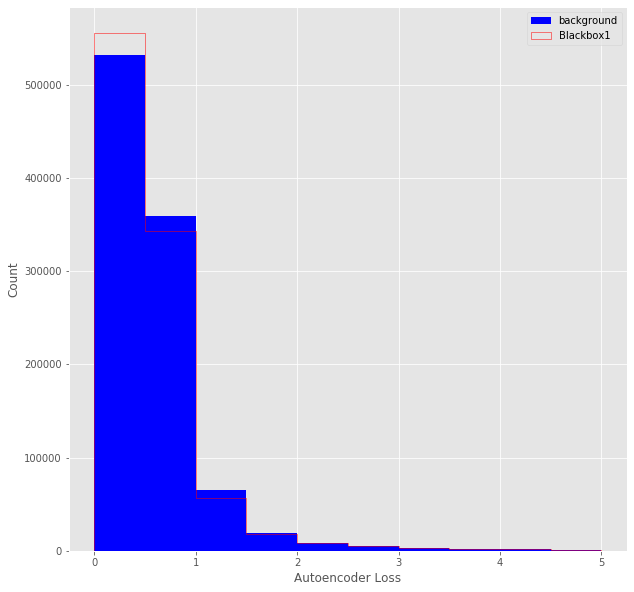

In [71]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,1001)
plt.hist(purebkgloss[np.where(purebkgloss<10)[0]],bins=bins,label='background',color="blue");
plt.hist(bb2loss[np.where(bb2loss<10)[0]],bins=bins,label='Blackbox1',histtype='step',color="red");
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.savefig("/home/spark/LHCOlympics/LHC-Olympics/Code/AnalysisBB1/nf_vae_loss.png")
plt.show()

## Calculate SF in two different ways¶


In [28]:
# SF from mass sideband
Numbb2_m = np.where((bb2mass<2200))[0]
NumPureBkg_m = np.where((purebkgmass<2200))[0]
sf1 = Numbb2_m.shape[0]/NumPureBkg_m.shape[0]
print(sf1)

1.4338323868525211


In [29]:
bb1_bkgAE_Num = np.where((bb2loss<0.5))[0].shape[0]
purebkg_bkgAE_Num = np.where((purebkgloss<0.5))[0].shape[0]
sf2 = bb1_bkgAE_Num/purebkg_bkgAE_Num
print(sf2)

1.0450797988756217


## Cut on Loss, Plot the Variables¶


In [30]:
bb2_bkgAE_index = np.where((bb2loss>10.0)&(bb2loss<70.0))[0]
print(bb2_bkgAE_index.shape)
purebkg_bkgAE_index = np.where((purebkgloss>10.0)&(purebkgloss<70.0))[0]
print(purebkg_bkgAE_index.shape)

(1051,)
(570,)


In [31]:
for N in range(10,25):
    bb2_bkgAE_index_temp = np.where((bb2loss>N))[0]
    #print(bb2_bkgAE_index.shape)
    purebkg_bkgAE_index_temp = np.where((purebkgloss>N))[0]
    #print(purebkg_bkgAE_index.shape)
    print(N, bb2_bkgAE_index_temp.shape[0]/purebkg_bkgAE_index_temp.shape[0])

10 1.851027397260274
11 1.94
12 2.0898550724637683
13 2.2463235294117645
14 2.321266968325792
15 2.5714285714285716
16 2.63265306122449
17 2.775
18 2.9504950495049505
19 2.808988764044944
20 2.8641975308641974
21 2.9863013698630136
22 2.8955223880597014
23 2.918032786885246
24 3.1296296296296298


Text(0.5, 1.0, '$m_{JJ}$ without SF')

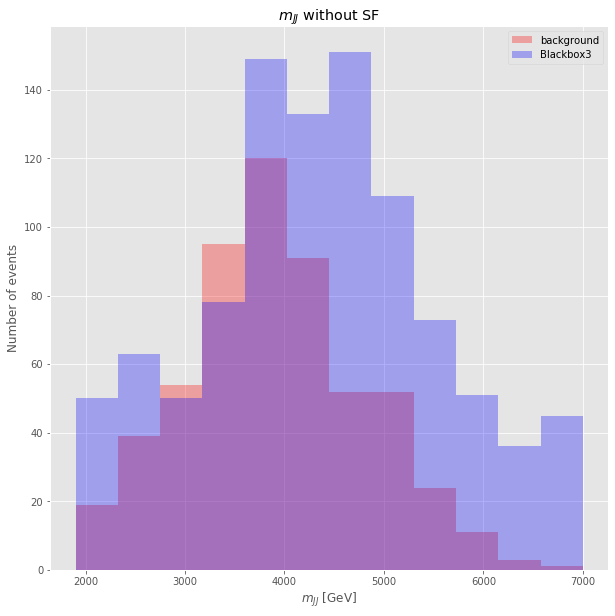

In [32]:
#### Without Scalefactor
plt.style.use('ggplot')
bins = np.linspace(1900,7000,13)
plt.hist(purebkgmass[purebkg_bkgAE_index],bins=bins,alpha=0.3,color='r',label='background');
plt.hist(bb2mass[bb2_bkgAE_index],bins=bins,alpha=0.3,color='b',label='Blackbox3');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
# plt.savefig("AnalysisBB2/bkgAEcut_mjj_noscalefactor.png")

In [33]:
bb2_bkgAE_selected_mmdt1 = bb2mmdt1[bb2_bkgAE_index]
PureBkg_bkgAE_selected_mmdt1 = purebkgmmdt1[purebkg_bkgAE_index]

In [34]:
bb2bkgAE_selected_mmdt2 = bb2mmdt2[bb2_bkgAE_index]
PureBkg_bkgAE_selected_mmdt2 = purebkgmmdt2[purebkg_bkgAE_index]

Text(0.5, 1.0, 'mMDT leading jet with bkg AE cut')

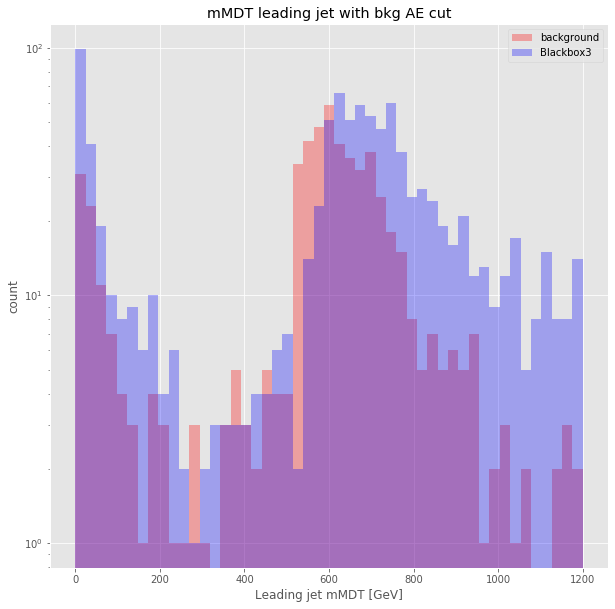

In [35]:
# plot mmdt masses jet 1 
plt.style.use('ggplot')
bins = np.linspace(0,1200,50)
plt.hist(PureBkg_bkgAE_selected_mmdt1,bins=bins,alpha=0.3,color='r',label='background');
plt.hist(bb2_bkgAE_selected_mmdt1,bins=bins,alpha=0.3,color='b',label='Blackbox3');
plt.semilogy()
plt.xlabel(r'Leading jet mMDT [GeV]')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('mMDT leading jet with bkg AE cut')
# plt.savefig("AnalysisBB2/bkgAEcut_leadjetmmdt.png")
#plt.title('yes')

[]

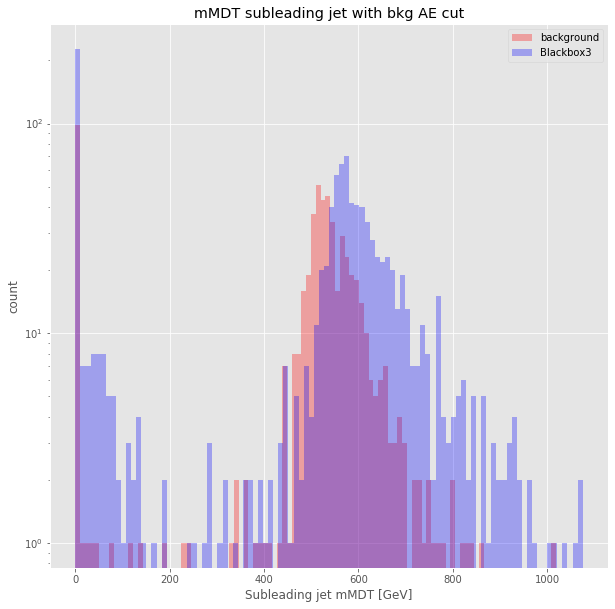

In [36]:
#plot mmdt masses jet 2 
plt.style.use('ggplot')
plt.hist(PureBkg_bkgAE_selected_mmdt2,100,alpha=0.3,color='r',label='background');
plt.hist(bb2bkgAE_selected_mmdt2,100,alpha=0.3,color='b',label='Blackbox3');
plt.xlabel(r'Subleading jet mMDT [GeV]')
plt.ylabel('count')
plt.title('mMDT subleading jet with bkg AE cut')
plt.legend(loc='upper right')
plt.semilogy()
# plt.savefig("AnalysisBB2/bkgAEcut_subleadjetmmdt.png")

Text(0.5, 1.0, '$m_{JJ}$ with SF')

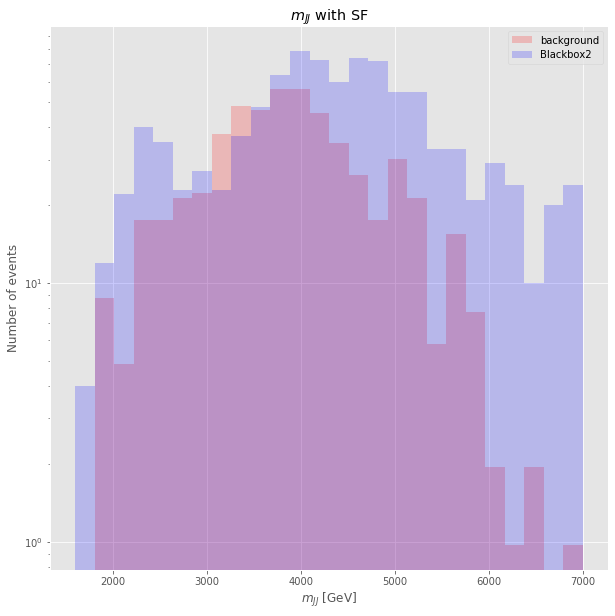

In [37]:
plt.rcParams["figure.figsize"] = (10,10)
#plt.yscale('log', nonposy='clip')
(counts, bins) = np.histogram(purebkgmass[purebkg_bkgAE_index], bins=np.linspace(1600, 7000, 27))
scalefactor = 0.97
_ = plt.hist(bins[:-1], bins, weights=scalefactor*counts,alpha=.2,color='r',label='background');

factor2 = 1
(counts2, bins2) = np.histogram(bb2mass[bb2_bkgAE_index], bins=np.linspace(1600, 7000, 27))
_ = plt.hist(bins2[:-1], bins2, weights=factor2*counts2,alpha=.2,color='b',label='Blackbox2');

plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')

plt.semilogy()
plt.title('$m_{JJ}$ with SF')

# plt.savefig("AnalysisBB2/bkgAEcut_mjj_withscalefactor.png")

#plt.hist(PureBkg_selection_based_on_bkg_selectedmass,60,alpha=0.2)
#plt.hist(BB1_selection_based_on_bkg_selectedmass,60,alpha=0.2)

In [39]:
f_background = pd.read_hdf('../../MassRatio_pureBkg.h5')
dt_background = f_background.values
f_bb = pd.read_hdf("../../MassRatio_BB1.h5")
dt_bb = f_bb.values

In [40]:
f_bb.columns

Index(['Mjj', 'Mj1', 'j1 tau21', 'j1 tau32', 'j1 tau43',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'j1 pT1', 'j1 M_trim',
       'j1 M_prun', 'j1 M_mmdt', 'j1 M_sdb1', 'j1 M_sdb2', 'j1 M_sdm1', 'Mj2',
       'j2 tau21', 'j2 tau32', 'j2 tau43', 'j2 sqrt(tau^2_1)/tau^1_1',
       'j2 n_trk', 'j2 pT1', 'j2 M_trim', 'j2 M_prun', 'j2 M_mmdt',
       'j2 M_sdb1', 'j2 M_sdb2', 'j2 M_sdm1'],
      dtype='object')

In [41]:
variable = [r'$\tau_{21}$',r'$\tau_{32}$',r'$\tau_{43}$']
jettype = [r'leading jet','subleading jet']
colindex = np.array([[2,3,4],[15,16,17]])
bins = np.linspace(0,1,26)

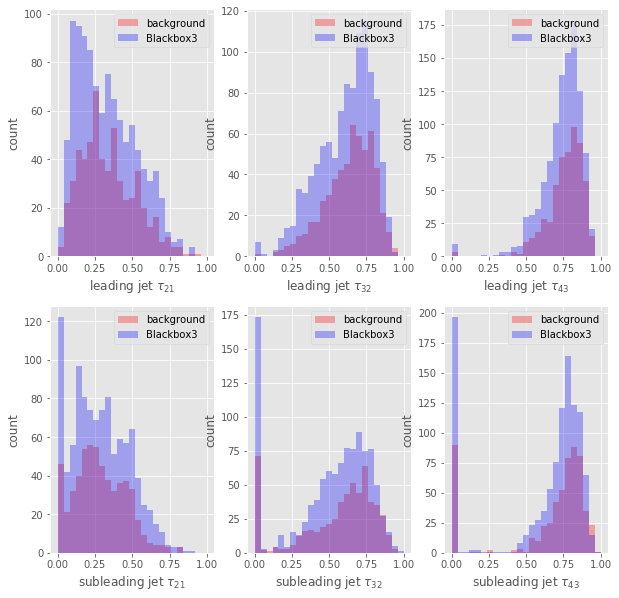

In [42]:
count = 1
#fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
for i,jetname in enumerate(jettype):
    for j,varname in enumerate(variable):
        plt.subplot(2,3,count)
        plt.hist(dt_background[purebkg_bkgAE_index,colindex[i,j]],bins=bins,alpha=0.3,color='r',label='background');
        plt.hist(dt_bb[bb2_bkgAE_index,colindex[i,j]],bins=bins,alpha=0.3,color='b',label='Blackbox3');
        plt.xlabel(jettype[i]+' '+variable[j])
        plt.legend(loc='upper right')
        plt.ylabel('count')
        count+=1

# Signal Autoencoder

In [198]:
if MODEL == 'VAE-NF':
    sig_model = VAE_NF(N_FLOWS, Z_DIM).cuda()
else:
    sig_model = VAE(Z_DIM).cuda()

In [199]:
sig_optimizer = optim.Adam(sig_model.parameters(), lr=LR)

In [204]:
sig_model.load_state_dict(torch.load("/home/spark/LHCOlympics/LHC-Olympics/weights_nf_vae/SIG_VAE_nf_sangeon_v1.h5"))

<All keys matched successfully>

In [205]:
def sigAE_get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])


    
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    loss_total_in = torch.mean((sig_model(total_in_selection.float().cuda())[0]-
                       total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [207]:
bb2mass, bb2mmdt1, bb2mmdt2, bb2prun1,bb2prun2, sigae_bb2loss = get_mass_and_loss("/data/t3home000/spark/MassRatio_BB3.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, sigae_purebkgloss = get_mass_and_loss("../../MassRatio_pureBkg.h5")

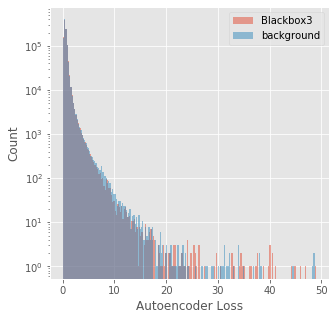

In [236]:
plt.rcParams["figure.figsize"] = (5,5)
plt.hist(sigae_bb2loss[np.where(sigae_bb2loss<50)[0]],200,alpha=0.5,label='Blackbox3');
plt.hist(sigae_purebkgloss[np.where(sigae_purebkgloss<50)[0]],200,alpha=0.5,label='background');
plt.semilogy()
#plt.semilogx()
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
#plt.savefig("../../Code/AnalysisBB2/NF_sig_autoencoder_loss.png")
plt.show()

# Cut on Both Signal and Background Autoencoder

In [ ]:
bb2_Combined_index = np.where((sigae_bb2loss<8.) & (bb2loss>4))[0]
print(bb2_Combined_index.shape)
purebkg_Combined_index = np.where((sigae_purebkgloss<8.) & (purebkgloss>4))[0]
print(purebkg_Combined_index.shape)

Text(0.5, 1.0, '$m_{JJ}$ without SF')

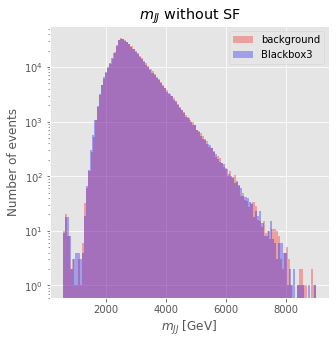

In [219]:
#### Without Scalefactor
plt.style.use('ggplot')
plt.hist(purebkgmass[purebkg_sigAE_index],120,alpha=0.3,color='r',label='background');
plt.hist(bb2mass[bb2_sigAE_index],120,alpha=0.3,color='b',label='Blackbox3');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.semilogy()
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
#plt.savefig("../../Code/AnalysisBB2/sigAEcut_mjj_noscalefactor.png")

Text(0.5, 1.0, '$m_{JJ}$ without SF')

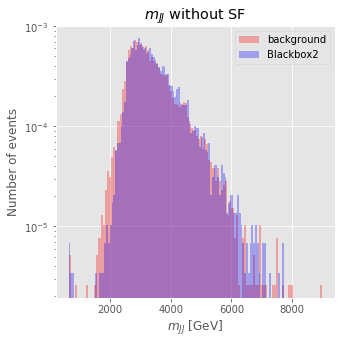

In [241]:
#### Without Scalefactor
plt.style.use('ggplot')
plt.hist(purebkgmass[purebkg_Combined_index],120,alpha=0.3,color='r',label='background',density=True);
plt.hist(bb2mass[bb2_Combined_index],120,alpha=0.3,color='b',label='Blackbox2',density=True);
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.semilogy()
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
#plt.savefig("../../Code/AnalysisBB2/sigAEcut_mjj_noscalefactor.png")

Text(0.5, 1.0, 'mMDT leading jet with bkg AE cut')

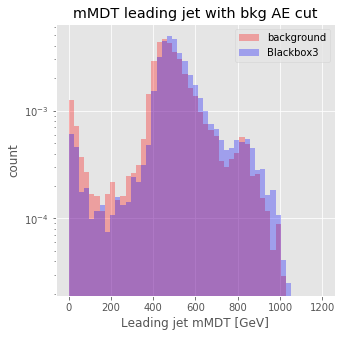

In [243]:
bb2_bkgAE_selected_mmdt1 = bb2mmdt1[bb2_Combined_index]
PureBkg_bkgAE_selected_mmdt1 = purebkgmmdt1[purebkg_Combined_index]
plt.style.use('ggplot')
bins = np.linspace(0,1200,50)
plt.hist(PureBkg_bkgAE_selected_mmdt1,bins=bins,alpha=0.3,color='r',label='background',density=True);
plt.hist(bb2_bkgAE_selected_mmdt1,bins=bins,alpha=0.3,color='b',label='Blackbox3',density=True);
plt.semilogy()
plt.xlabel(r'Leading jet mMDT [GeV]')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('mMDT leading jet with bkg AE cut')
# plt.savefig("AnalysisBB2/bkgAEcut_leadjetmmdt.png")
#plt.title('yes')

In [ ]:
plt.hist2d(dt_PureBkg[manual_index_from_mass,10],dt_PureBkg[manual_index_from_mass,23],50,range=[[100, 1500], [100 ,1500]]);

In [254]:
aescan[0,0] =1
print(aescan)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [250]:
sigae_bb2loss
sigae_purebkgloss
bb2loss
purebkgloss


array([0.5381994 , 0.32474184, 0.28056484, ..., 0.91547847, 0.2905921 ,
       0.66841686], dtype=float32)

In [330]:

aescan = np.zeros((100,100))
for N in range(0,100):
    for K in range(0,100):
        f = 0.05
        bb2_combinedAE_index_temp = np.where((bb2loss>N/2) & (sigae_bb2loss<K/2))[0]
        print(bb2_combinedAE_index_temp.shape)
        N_A = bb2_combinedAE_index_temp.shape[0]
        purebkg_combinedAE_index_temp = np.where((purebkgloss>N/2) & (sigae_bb2loss<K/2))[0]
        print(purebkg_combinedAE_index_temp.shape)
        N_B = purebkg_combinedAE_index_temp.shape[0]

        #print(N,K, bb2_combinedAE_index_temp.shape[0]/denom)
        aescan[N,K] = (N_A-N_B)/np.sqrt(N_A+N_B+(f*N_A)*(f*N_A)+(f*N_B)*(f*N_B))
        print(aescan[N,K])


(0,)
(0,)
nan
(513767,)
(513767,)
0.0
(885871,)
(885871,)
0.0
(955738,)
(955738,)
0.0
(975551,)
(975551,)
0.0
(984295,)
(984295,)
0.0
(989076,)
(989076,)
0.0
(992193,)
(992193,)
0.0
(994134,)
(994134,)
0.0
(995584,)
(995584,)
0.0
(996558,)
(996558,)
0.0
(997346,)
(997346,)
0.0
(997890,)
(997890,)
0.0
(998315,)
(998315,)
0.0
(998643,)
(998643,)
0.0
(998880,)
(998880,)
0.0
(999064,)
(999064,)
0.0
(999203,)
(999203,)
0.0
(999384,)
(999384,)
0.0
(999475,)
(999475,)
0.0
(999544,)
(999544,)
0.0
(999582,)
(999582,)
0.0
(999626,)
(999626,)
0.0
(999673,)
(999673,)
0.0
(999707,)
(999707,)
0.0
(999746,)
(999746,)
0.0
(999771,)
(999771,)
0.0
(999791,)
(999791,)
0.0
(999814,)
(999814,)
0.0
(999828,)
(999828,)
0.0
(999841,)
(999841,)
0.0
(999848,)
(999848,)
0.0
(999851,)
(999851,)
0.0
(999864,)
(999864,)
0.0
(999876,)
(999876,)
0.0
(999888,)
(999888,)
0.0
(999894,)
(999894,)
0.0
(999896,)
(999896,)
0.0
(999900,)
(999900,)
0.0
(999901,)
(999901,)
0.0
(999907,)
(999907,)
0.0
(999909,)
(999909,)
0.0
(9

/home/spark/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


(999966,)
(999966,)
0.0
(999969,)
(999969,)
0.0
(999971,)
(999971,)
0.0
(999972,)
(999972,)
0.0
(999973,)
(999973,)
0.0
(999973,)
(999973,)
0.0
(999973,)
(999973,)
0.0
(999973,)
(999973,)
0.0
(999973,)
(999973,)
0.0
(999973,)
(999973,)
0.0
(999974,)
(999974,)
0.0
(999976,)
(999976,)
0.0
(999976,)
(999976,)
0.0
(999977,)
(999977,)
0.0
(999977,)
(999977,)
0.0
(999978,)
(999978,)
0.0
(999978,)
(999978,)
0.0
(999978,)
(999978,)
0.0
(999978,)
(999978,)
0.0
(999978,)
(999978,)
0.0
(999979,)
(999979,)
0.0
(0,)
(0,)
nan
(7409,)
(243758,)
-19.36679935727848
(371807,)
(420652,)
-1.7391883556388992
(441670,)
(453610,)
-0.37701436828543844
(461483,)
(463039,)
-0.04758268037622109
(470227,)
(467138,)
0.0931679555461239
(475008,)
(469356,)
0.1692061242580916
(478125,)
(470865,)
0.2162839547654977
(480066,)
(471745,)
0.24715578390365536
(481516,)
(472450,)
0.26867434135582313
(482490,)
(472907,)
0.28356918115595525
(483278,)
(473287,)
0.2952801606582867
(483822,)
(473538,)
0.30368641838190386
(484247

(44137,)
(45110,)
-0.3069734511988231
(44139,)
(45110,)
-0.30633570823819833
(44142,)
(45110,)
-0.3053791462741119
(44143,)
(45110,)
-0.30506030627947495
(44149,)
(45110,)
-0.30314741323465777
(44150,)
(45110,)
-0.3028286222133406
(44153,)
(45110,)
-0.30187229112347486
(44155,)
(45110,)
-0.3012347720408814
(44157,)
(45110,)
-0.3005972809391261
(44162,)
(45110,)
-0.299003675595192
(44166,)
(45111,)
-0.29804094979316337
(44169,)
(45111,)
-0.2970849550044466
(44172,)
(45111,)
-0.29612902315708234
(44175,)
(45111,)
-0.29517315424813073
(44175,)
(45111,)
-0.29517315424813073
(44176,)
(45111,)
-0.29485454526428595
(44176,)
(45111,)
-0.29485454526428595
(44176,)
(45111,)
-0.29485454526428595
(44176,)
(45111,)
-0.29485454526428595
(44177,)
(45111,)
-0.29453594327316257
(44179,)
(45112,)
-0.29421078816572266
(44179,)
(45112,)
-0.29421078816572266
(44180,)
(45112,)
-0.29389220733474136
(44180,)
(45112,)
-0.29389220733474136
(44180,)
(45112,)
-0.29389220733474136
(44180,)
(45112,)
-0.293892207334

(12037,)
-1.4159215929246036
(10871,)
(12037,)
-1.4133821081874387
(10871,)
(12037,)
-1.4133821081874387
(10873,)
(12037,)
-1.4108430250997233
(10876,)
(12037,)
-1.407035153487147
(10877,)
(12037,)
-1.4057660637378226
(10877,)
(12037,)
-1.4057660637378226
(10879,)
(12037,)
-1.4032281853961568
(10879,)
(12037,)
-1.4032281853961568
(10880,)
(12037,)
-1.4019593967953694
(10882,)
(12037,)
-1.3994221207127566
(10882,)
(12037,)
-1.3994221207127566
(10883,)
(12037,)
-1.3981536332224744
(10883,)
(12037,)
-1.3981536332224744
(10886,)
(12037,)
-1.3943487729049446
(10888,)
(12037,)
-1.3918127011120034
(10889,)
(12037,)
-1.390544815728441
(10890,)
(12037,)
-1.389277030681162
(10890,)
(12037,)
-1.389277030681162
(10890,)
(12037,)
-1.389277030681162
(10890,)
(12037,)
-1.389277030681162
(10890,)
(12037,)
-1.389277030681162
(10890,)
(12037,)
-1.389277030681162
(10891,)
(12037,)
-1.3880093459659226
(10893,)
(12037,)
-1.3854742775145783
(10893,)
(12037,)
-1.3854742775145783
(10894,)
(12037,)
-1.38420689

(4372,)
(5260,)
-2.495849998854349
(4373,)
(5260,)
-2.492814257186885
(4375,)
(5260,)
-2.4867443317048625
(4375,)
(5260,)
-2.4867443317048625
(4376,)
(5260,)
-2.4837101478356094
(4376,)
(5260,)
-2.4837101478356094
(4379,)
(5260,)
-2.474610711385329
(4381,)
(5260,)
-2.468547016107095
(4382,)
(5260,)
-2.4655159470914327
(4383,)
(5260,)
-2.4624853971209744
(4383,)
(5260,)
-2.4624853971209744
(4383,)
(5260,)
-2.4624853971209744
(4383,)
(5260,)
-2.4624853971209744
(4383,)
(5260,)
-2.4624853971209744
(4383,)
(5260,)
-2.4624853971209744
(4384,)
(5260,)
-2.459455366167812
(4386,)
(5260,)
-2.453396861201419
(4386,)
(5260,)
-2.453396861201419
(4387,)
(5260,)
-2.4503683871320456
(4387,)
(5260,)
-2.4503683871320456
(4388,)
(5260,)
-2.4473404319676844
(4388,)
(5260,)
-2.4473404319676844
(4388,)
(5260,)
-2.4473404319676844
(4388,)
(5260,)
-2.4473404319676844
(4388,)
(5260,)
-2.4473404319676844
(4389,)
(5260,)
-2.4443129956800993
(0,)
(0,)
nan
(0,)
(2086,)
-18.320468925692943
(0,)
(3659,)
-18.9889816

(0,)
(0,)
nan
(0,)
(1129,)
-17.18593733606148
(0,)
(1969,)
-18.2335118391665
(0,)
(2116,)
-18.3414011250647
(0,)
(2160,)
-18.371173070873834
(0,)
(2185,)
-18.38761672274976
(0,)
(2198,)
-18.39603665853352
(0,)
(2204,)
-18.399893140676813
(0,)
(2205,)
-18.400534082209585
(0,)
(2212,)
-18.405006310080942
(0,)
(2214,)
-18.40627949133348
(0,)
(2219,)
-18.409453553679793
(0,)
(2219,)
-18.409453553679793
(3,)
(2219,)
-18.382652697205405
(330,)
(2219,)
-15.35663117281575
(567,)
(2219,)
-13.101366694223454
(751,)
(2219,)
-11.363160036872722
(890,)
(2220,)
-10.079446064501301
(1071,)
(2220,)
-8.452276896137128
(1162,)
(2221,)
-7.664518757835119
(1231,)
(2221,)
-7.076393717539924
(1269,)
(2221,)
-6.757382737983573
(1313,)
(2221,)
-6.392460377925655
(1360,)
(2221,)
-6.008050385138585
(1394,)
(2221,)
-5.733497669611337
(1433,)
(2221,)
-5.422269007713282
(1458,)
(2221,)
-5.224861701228898
(1478,)
(2221,)
-5.068124097785348
(1501,)
(2221,)
-4.8891877143166305
(1515,)
(2221,)
-4.780959382556176
(1528

(1207,)
-5.226683584830475
(780,)
(1208,)
-5.0591016548463354
(787,)
(1208,)
-4.964435383796849
(790,)
(1208,)
-4.923985872289677
(803,)
(1208,)
-4.749550400704303
(815,)
(1208,)
-4.589755394265947
(827,)
(1208,)
-4.431136581849692
(833,)
(1208,)
-4.352268930444292
(835,)
(1208,)
-4.326045215081019
(839,)
(1208,)
-4.273696080857903
(840,)
(1208,)
-4.260629280607457
(846,)
(1208,)
-4.182400597091761
(848,)
(1208,)
-4.1563899542959435
(851,)
(1208,)
-4.117435492790043
(852,)
(1208,)
-4.104467075153837
(858,)
(1208,)
-4.0268288321589205
(859,)
(1208,)
-4.013917839236363
(862,)
(1208,)
-3.9752340917136966
(864,)
(1208,)
-3.949485955469884
(866,)
(1208,)
-3.9237706443749505
(871,)
(1208,)
-3.8596259851419843
(875,)
(1208,)
-3.8084579855648744
(878,)
(1208,)
-3.770168160987899
(881,)
(1208,)
-3.731952198744685
(884,)
(1208,)
-3.6938100951178248
(884,)
(1208,)
-3.6938100951178248
(885,)
(1208,)
-3.6811124727112237
(885,)
(1208,)
-3.6811124727112237
(885,)
(1208,)
-3.6811124727112237
(885,)
(1

(468,)
(684,)
-4.032490380647244
(468,)
(684,)
-4.032490380647244
(469,)
(684,)
-4.0114855159927165
(469,)
(684,)
-4.0114855159927165
(469,)
(684,)
-4.0114855159927165
(469,)
(684,)
-4.0114855159927165
(470,)
(684,)
-3.9905029666035152
(472,)
(684,)
-3.948604806000033
(472,)
(684,)
-3.948604806000033
(473,)
(684,)
-3.9276891906025546
(473,)
(684,)
-3.9276891906025546
(473,)
(684,)
-3.9276891906025546
(473,)
(684,)
-3.9276891906025546
(475,)
(684,)
-3.8859248780483524
(477,)
(684,)
-3.8442497726797082
(477,)
(684,)
-3.8442497726797082
(479,)
(684,)
-3.80266385189958
(482,)
(684,)
-3.740452136740717
(483,)
(684,)
-3.7197594622270964
(483,)
(684,)
-3.7197594622270964
(485,)
(684,)
-3.6784409367249262
(485,)
(684,)
-3.6784409367249262
(486,)
(684,)
-3.657815077820758
(488,)
(684,)
-3.6166301468825175
(488,)
(684,)
-3.6166301468825175
(489,)
(684,)
-3.59607106610825
(489,)
(684,)
-3.59607106610825
(492,)
(684,)
-3.5345273072772505
(494,)
(684,)
-3.4936093222095113
(495,)
(684,)
-3.473183670

(0,)
(389,)
-14.043206910443606
(0,)
(390,)
-14.05234337861055
(0,)
(391,)
-14.061450831770916
(0,)
(391,)
-14.061450831770916
(0,)
(391,)
-14.061450831770916
(0,)
(391,)
-14.061450831770916
(0,)
(391,)
-14.061450831770916
(0,)
(391,)
-14.061450831770916
(0,)
(391,)
-14.061450831770916
(0,)
(391,)
-14.061450831770916
(0,)
(392,)
-14.070529413628968
(0,)
(392,)
-14.070529413628968
(0,)
(392,)
-14.070529413628968
(0,)
(392,)
-14.070529413628968
(0,)
(392,)
-14.070529413628968
(33,)
(392,)
-12.599341817157777
(72,)
(392,)
-10.904810934793742
(97,)
(392,)
-9.85150697096046
(117,)
(392,)
-9.03032219007532
(140,)
(392,)
-8.111494600104198
(154,)
(392,)
-7.566238566271907
(167,)
(392,)
-7.06973254403721
(174,)
(392,)
-6.806354456210357
(177,)
(392,)
-6.694336328041255
(190,)
(392,)
-6.214913917835514
(202,)
(392,)
-5.781060911774985
(214,)
(392,)
-5.355594092789735
(220,)
(392,)
-5.146011568923312
(222,)
(392,)
-5.076617642967077
(226,)
(392,)
-4.938529963078156
(227,)
(392,)
-4.9041538684878

(57,)
(271,)
-9.387003275128698
(70,)
(271,)
-8.67498170352796
(77,)
(271,)
-8.299204181388681
(80,)
(271,)
-8.139810189073177
(93,)
(271,)
-7.460673241697241
(105,)
(271,)
-6.850590500744084
(117,)
(271,)
-6.256725840872672
(123,)
(271,)
-5.965874981679595
(125,)
(271,)
-5.869824034794023
(129,)
(271,)
-5.679068709091302
(130,)
(271,)
-5.631660055124926
(136,)
(271,)
-5.349556136425339
(138,)
(271,)
-5.256414035593036
(141,)
(271,)
-5.117535184362937
(142,)
(271,)
-5.071464324159364
(148,)
(271,)
-4.797363743912186
(149,)
(271,)
-4.752066697671738
(152,)
(271,)
-4.616835556768502
(154,)
(271,)
-4.527230204358054
(156,)
(271,)
-4.438062630823064
(161,)
(271,)
-4.217051812368234
(165,)
(271,)
-4.04219634394036
(168,)
(271,)
-3.9121878053054493
(171,)
(271,)
-3.783145759896046
(174,)
(271,)
-3.65506582308535
(174,)
(271,)
-3.65506582308535
(175,)
(271,)
-3.6125855356622916
(175,)
(271,)
-3.6125855356622916
(175,)
(271,)
-3.6125855356622916
(175,)
(271,)
-3.6125855356622916
(176,)
(271,)


(197,)
-2.3453303971349397
(145,)
(197,)
-2.3453303971349397
(145,)
(197,)
-2.3453303971349397
(145,)
(197,)
-2.3453303971349397
(145,)
(197,)
-2.3453303971349397
(145,)
(197,)
-2.3453303971349397
(146,)
(197,)
-2.2961968457407926
(148,)
(197,)
-2.1984314874398434
(148,)
(197,)
-2.1984314874398434
(149,)
(197,)
-2.1497985532994286
(149,)
(197,)
-2.1497985532994286
(150,)
(197,)
-2.1013313640503393
(150,)
(197,)
-2.1013313640503393
(150,)
(197,)
-2.1013313640503393
(150,)
(197,)
-2.1013313640503393
(150,)
(197,)
-2.1013313640503393
(151,)
(197,)
-2.053029355703835
(0,)
(0,)
nan
(0,)
(93,)
-8.686563730977436
(0,)
(155,)
-10.569376126891866
(0,)
(166,)
-10.831181266718271
(0,)
(168,)
-10.877033564117083
(0,)
(169,)
-10.899767011908281
(0,)
(171,)
-10.944854607612946
(0,)
(172,)
-10.967211144120473
(0,)
(172,)
-10.967211144120473
(0,)
(173,)
-10.989444403933955
(0,)
(174,)
-11.011555539554658
(0,)
(174,)
-11.011555539554658
(0,)
(174,)
-11.011555539554658
(0,)
(174,)
-11.011555539554658
(0

(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(0,)
(132,)
-9.962335082737976
(12,)
(132,)
-8.753762190648171
(24,)
(132,)
-7.617732651272862
(30,)
(132,)
-7.075659911805192
(32,)
(132,)
-6.898684822115773
(36,)
(132,)
-6.550192969139221
(37,)
(132,)
-6.464193130657348
(43,)
(132,)
-5.957443574006613
(45,)
(132,)
-5.791993276792174
(48,)

(100,)
-8.94427190999916
(0,)
(100,)
-8.94427190999916
(0,)
(100,)
-8.94427190999916
(2,)
(100,)
-8.695751446597713
(6,)
(100,)
-8.209998388383791
(7,)
(100,)
-8.090857592046076
(13,)
(100,)
-7.394620804324442
(15,)
(100,)
-7.169422745164941
(18,)
(100,)
-6.837845901238504
(19,)
(100,)
-6.728946566826645
(25,)
(100,)
-6.092076990801714
(26,)
(100,)
-5.98861539172787
(29,)
(100,)
-5.6826828596141015
(31,)
(100,)
-5.482366624707349
(33,)
(100,)
-5.284896216169169
(38,)
(100,)
-4.803315982433928
(42,)
(100,)
-4.43006314004338
(45,)
(100,)
-4.156866971692728
(48,)
(100,)
-3.8892706891681805
(51,)
(100,)
-3.627117886780148
(51,)
(100,)
-3.627117886780148
(52,)
(100,)
-3.540916994931938
(52,)
(100,)
-3.540916994931938
(52,)
(100,)
-3.540916994931938
(52,)
(100,)
-3.540916994931938
(53,)
(100,)
-3.4552986107191654
(55,)
(100,)
-3.2857877593661056
(55,)
(100,)
-3.2857877593661056
(56,)
(100,)
-3.201884638836191
(56,)
(100,)
-3.201884638836191
(56,)
(100,)
-3.201884638836191
(56,)
(100,)
-3.201

(84,)
-3.260773253630123
(44,)
(84,)
-3.260773253630123
(45,)
(84,)
-3.166417944694683
(47,)
(84,)
-2.9799731553298696
(47,)
(84,)
-2.9799731553298696
(48,)
(84,)
-2.887865706671337
(48,)
(84,)
-2.887865706671337
(48,)
(84,)
-2.887865706671337
(48,)
(84,)
-2.887865706671337
(50,)
(84,)
-2.7058368354212954
(52,)
(84,)
-2.5266657674194617
(52,)
(84,)
-2.5266657674194617
(54,)
(84,)
-2.3502860668094647
(57,)
(84,)
-2.0908099854656066
(58,)
(84,)
-2.0056451126165293
(58,)
(84,)
-2.0056451126165293
(60,)
(84,)
-1.8372608486985014
(60,)
(84,)
-1.8372608486985014
(61,)
(84,)
-1.7540267709467054
(63,)
(84,)
-1.5894388284780527
(63,)
(84,)
-1.5894388284780527
(64,)
(84,)
-1.508070925640246
(64,)
(84,)
-1.508070925640246
(67,)
(84,)
-1.2675894284842186
(69,)
(84,)
-1.1102205505657683
(70,)
(84,)
-1.0324023377450031
(71,)
(84,)
-0.9551532011625855
(71,)
(84,)
-0.9551532011625855
(71,)
(84,)
-0.9551532011625855
(71,)
(84,)
-0.9551532011625855
(71,)
(84,)
-0.9551532011625855
(71,)
(84,)
-0.95515320

(66,)
(74,)
-0.6235933252642566
(66,)
(74,)
-0.6235933252642566
(66,)
(74,)
-0.6235933252642566
(66,)
(74,)
-0.6235933252642566
(67,)
(74,)
-0.5434486150477502
(0,)
(0,)
nan
(0,)
(40,)
-6.030226891555272
(0,)
(63,)
-7.377509457014401
(0,)
(68,)
-7.623624998624875
(0,)
(69,)
-7.671285033975382
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498795975
(0,)
(70,)
-7.7184498498

(4,)
(62,)
-6.668428936500955
(9,)
(62,)
-5.895716588444583
(13,)
(62,)
-5.31378044385298
(16,)
(62,)
-4.896665917793615
(19,)
(62,)
-4.4949849879998425
(22,)
(62,)
-4.10780685998054
(22,)
(62,)
-4.10780685998054
(23,)
(62,)
-3.981820937101362
(23,)
(62,)
-3.981820937101362
(23,)
(62,)
-3.981820937101362
(23,)
(62,)
-3.981820937101362
(24,)
(62,)
-3.857321400587351
(26,)
(62,)
-3.6126665382534706
(26,)
(62,)
-3.6126665382534706
(27,)
(62,)
-3.4924557129800053
(27,)
(62,)
-3.4924557129800053
(27,)
(62,)
-3.4924557129800053
(27,)
(62,)
-3.4924557129800053
(29,)
(62,)
-3.256134155490866
(31,)
(62,)
-3.0251101654179684
(31,)
(62,)
-3.0251101654179684
(33,)
(62,)
-2.7991899830237066
(36,)
(62,)
-2.4694799205568323
(37,)
(62,)
-2.3619352896604164
(37,)
(62,)
-2.3619352896604164
(39,)
(62,)
-2.15026060532632
(39,)
(62,)
-2.15026060532632
(40,)
(62,)
-2.046091165622872
(42,)
(62,)
-1.8409932260318624
(42,)
(62,)
-1.8409932260318624
(43,)
(62,)
-1.7400281563897895
(43,)
(62,)
-1.740028156389789

(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(0,)
(53,)
-6.840988013276481
(3,)
(53,)
-6.2971592994842
(6,)
(53,)
-5.780375717006627
(9,)
(53,)
-5.2883622236972885
(9,)
(53,)
-5.2883622236972885
(10,)
(53,)
-5.129508496163811
(10,)
(53,)
-5.129508496163811
(10,)
(53,)
-5.129508496163811
(10,)
(53,)
-5.129508496163811
(11,)
(53,)
-4.973113833277715
(13,)
(53,)
-4.6674413965845085
(13,)
(53,)
-4.6674413965845085
(14,)
(53,)
-4.5180396673593854
(14,)
(53,)
-4.5180396673593854
(14,)
(53,)
-4.5180396673593854
(14,)
(53,)
-4.518039667359385

(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(0,)
(51,)
-6.72553462295179
(1,)
(51,)
-6.536925154799174
(1,)
(51,)
-6.536925154799174
(1,)
(51,)
-6.536925154799174
(1,)
(51,)
-6.536925154799174
(2,)
(51,)
-6.351729327390707
(4,)
(51,)
-5.991151347043059
(4,)
(51,)
-5.991151347043059
(5,)
(51,)
-5.815567585421544
(5,)
(51,)
-5.815567585421544
(5,)
(51,)
-5.815567585421544
(5,)
(51,)
-5.815567585421544
(7,)
(51,)
-5.473339639425881
(9,)
(51,)
-5.142450217873781
(9,)
(51,)
-5.142450217873781
(11,)
(51,)
-4.822252997671154
(14,)
(51,)
-4.360718944010289
(15,)
(51,)
-4.211606685888025
(15,)
(51,)
-4.211606685888025
(17,)
(51,)
-3.9201060748936474
(17,)
(51,)
-3.9201060748936474
(18,)
(51,)
-3.77760

(16,)
(49,)
-3.898778600874508
(16,)
(49,)
-3.898778600874508
(17,)
(49,)
-3.752391239429923
(19,)
(49,)
-3.466297632597614
(19,)
(49,)
-3.466297632597614
(20,)
(49,)
-3.326473429839027
(20,)
(49,)
-3.326473429839027
(23,)
(49,)
-2.9192299603317404
(25,)
(49,)
-2.6574146289707756
(26,)
(49,)
-2.5292675669310363
(27,)
(49,)
-2.4029011196125514
(27,)
(49,)
-2.4029011196125514
(27,)
(49,)
-2.4029011196125514
(27,)
(49,)
-2.4029011196125514
(27,)
(49,)
-2.4029011196125514
(27,)
(49,)
-2.4029011196125514
(28,)
(49,)
-2.27827242263077
(30,)
(49,)
-2.034064223661809
(30,)
(49,)
-2.034064223661809
(31,)
(49,)
-1.9144061944706894
(31,)
(49,)
-1.9144061944706894
(32,)
(49,)
-1.7963287364840803
(32,)
(49,)
-1.7963287364840803
(32,)
(49,)
-1.7963287364840803
(32,)
(49,)
-1.7963287364840803
(32,)
(49,)
-1.7963287364840803
(33,)
(49,)
-1.6797958122316092
(0,)
(0,)
nan
(0,)
(27,)
-5.029188806044013
(0,)
(46,)
-6.423052652840853
(0,)
(47,)
-6.485226715242763
(0,)
(47,)
-6.485226715242763
(0,)
(48,)
-6

-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.423052652840853
(0,)
(46,)
-6.4230526

(39,)
-1.8157823690094779
(26,)
(39,)
-1.548359830612064
(26,)
(39,)
-1.548359830612064
(27,)
(39,)
-1.4179108590417389
(27,)
(39,)
-1.4179108590417389
(28,)
(39,)
-1.2895520583723492
(28,)
(39,)
-1.2895520583723492
(28,)
(39,)
-1.2895520583723492
(28,)
(39,)
-1.2895520583723492
(28,)
(39,)
-1.2895520583723492
(29,)
(39,)
-1.163223290829637
(0,)
(0,)
nan
(0,)
(20,)
-4.364357804719848
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5.746957711326908
(0,)
(36,)
-5

-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(0,)
(32,)
-5.443310539518174
(2,)
(32,)
-4.960880601391585
(5,)
(32,)
-4.289363255541524
(6,)
(32,)
-4.077961046609319
(6,)
(32,)
-4.077961046609319
(8,)
(32,)
-3.6719403681726277
(8,)
(32,)
-3.6719403681726277
(9,)
(32,)
-3.4767765047993056
(11,)
(32,)
-3.100

(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.363795449504942
(0,)
(31,)
-5.3

(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.282705437953743
(0,)
(30,)
-5.2

(27,)
-5.029188806044013
(3,)
(27,)
-4.252953311523098
(5,)
(27,)
-3.77936586155387
(6,)
(27,)
-3.5540932665545544
(7,)
(27,)
-3.3358825509803514
(7,)
(27,)
-3.3358825509803514
(7,)
(27,)
-3.3358825509803514
(7,)
(27,)
-3.3358825509803514
(7,)
(27,)
-3.3358825509803514
(7,)
(27,)
-3.3358825509803514
(8,)
(27,)
-3.1243197055774186
(10,)
(27,)
-2.7196519068324627
(10,)
(27,)
-2.7196519068324627
(11,)
(27,)
-2.525878521484347
(11,)
(27,)
-2.525878521484347
(12,)
(27,)
-2.337410041879489
(12,)
(27,)
-2.337410041879489
(12,)
(27,)
-2.337410041879489
(12,)
(27,)
-2.337410041879489
(12,)
(27,)
-2.337410041879489
(13,)
(27,)
-2.15397361167707
(0,)
(0,)
nan
(0,)
(16,)
-3.9223227027636804
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-

(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)

(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(1,)
(27,)
-4.760834909555632
(3,)
(27,)
-4.252953311523098
(3,)
(27,)
-4.252953311523098
(4,)
(27,)
-4.012153465150525
(4,)
(27,)
-4.012153465150525
(5,)
(27,)
-3.77936586155387
(5,)
(27,)
-3.77936586155387
(5,)
(27,)
-3.77936586155387
(5,)
(27,)
-3.77936586155387
(5,)
(27,)
-3.77936586155387
(6,)
(27,)
-3.5540932665545544
(0,)
(0,)
nan
(0,)
(16,)
-3.9223227027636804
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013
(0,)
(27,)
-5.029188806044013

-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.8507125

-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(1,)
(25,)
-4.571221264507329
(1,)
(25,)
-4.571221264507329
(1,)
(25,)
-4.571221264507329
(1,)
(25,)
-4.571221264507329
(1,)
(25,)
-4.571221264507329
(2,)
(25,)
-4.30282531757167
(0,)
(0,)
nan
(0,)
(16,)
-3.9223227027636804
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(25,)
-4.850712500726659
(0,)
(2

(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(0,)
(23,)
-4.6636261624889634
(1,)
(23,)
-4.371675863090146
(0,)
(0,)
nan
(0,)
(14,)
-3.677848562449136
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.566517334766219
(0,)
(22,)
-4.56

In [264]:
plt.hist2d(aescan)

TypeError: hist2d() missing 1 required positional argument: 'y'

Text(0, 0.5, 'sig AE loss')

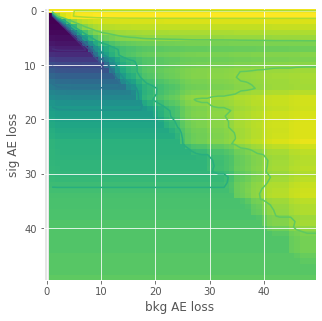

In [272]:
from mpl_toolkits.mplot3d import Axes3D
plt.contour(np.linspace(0,50,50),np.linspace(0,50,50),aescan)
plt.imshow(aescan)
plt.xlabel('bkg AE loss')
plt.ylabel('sig AE loss')

In [291]:
aescan[np.where(aescan<0)] = 0

/home/spark/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


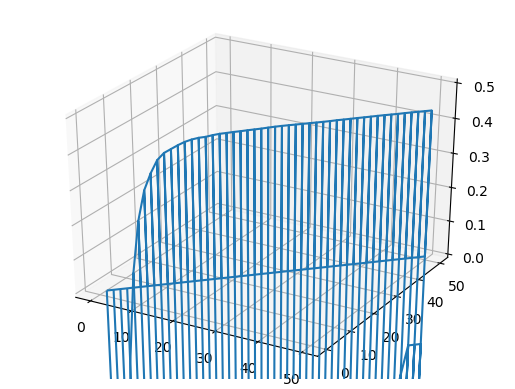

In [306]:
from matplotlib import cm
plt.style.use('default')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim([0,0.5])
surf = ax.plot_wireframe(np.linspace(0,50,50),np.linspace(0,50,50),aescan,cmap=cm.coolwarm)
#fig.colorbar(surf, shrink=0.5, aspect=5)

In [308]:
print(aescan,)

[[         nan   0.           0.         ...   0.           0.
    0.        ]
 [         nan -19.66413082  -2.60278158 ...   0.42869888   0.42869888
    0.42869888]
 [         nan -19.81319843 -19.74466478 ...  -0.7225554   -0.7225554
   -0.7225554 ]
 ...
 [         nan  -4.8507125   -4.8507125  ...  -4.8507125   -4.8507125
   -4.8507125 ]
 [         nan  -4.8507125   -4.8507125  ...  -4.8507125   -4.8507125
   -4.8507125 ]
 [         nan  -4.56651733  -4.56651733 ...  -4.56651733  -4.56651733
   -4.56651733]]


In [331]:
aescan_filtered = np.nan_to_num(aescan)

In [332]:
print(aescan_filtered)

[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.         -19.36679936  -1.73918836 ...   0.33628023   0.33628023
    0.33630932]
 [  0.         -19.92557681 -19.66413082 ...   0.42869888   0.42869888
    0.42882252]
 ...
 [  0.          -3.67784856  -4.66362616 ...  -4.66362616  -4.66362616
   -4.37167586]
 [  0.          -3.67784856  -4.56651733 ...  -4.56651733  -4.56651733
   -4.26775498]
 [  0.          -3.67784856  -4.56651733 ...  -4.56651733  -4.56651733
   -4.56651733]]


In [333]:
ind = np.unravel_index(np.argmax(aescan_filtered, axis=None), aescan_filtered.shape)

In [334]:
print(ind)

(2, 99)


In [336]:
aescan_filtered[2,4]
aescan_filtered[2,99]

0.4288225199614817

In [359]:
bb2_Combined_index = np.where((sigae_bb2loss<50.) & (bb2loss>1))[0]
print(bb2_Combined_index.shape)
purebkg_Combined_index = np.where((sigae_purebkgloss<50.) & (purebkgloss>1))[0]
print(purebkg_Combined_index.shape)

(114118,)
(110684,)


Text(0.5, 1.0, '$m_{JJ}$ without SF')

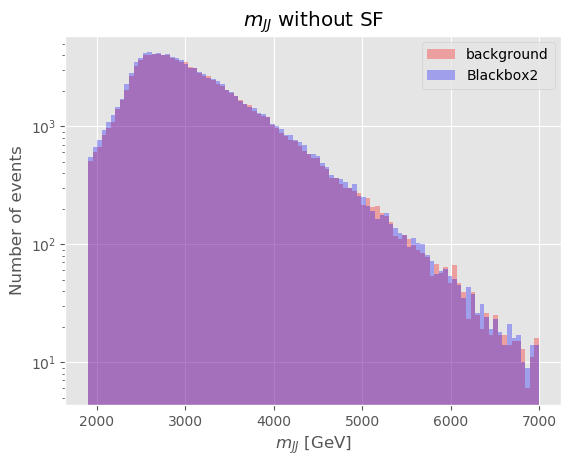

In [368]:
#### Without Scalefactor
plt.style.use('ggplot')
bins = np.linspace(1900,7000,100)
plt.hist(purebkgmass[purebkg_Combined_index],bins=bins,alpha=0.3,color='r',label='background');
plt.hist(bb2mass[bb2_Combined_index],bins=bins,alpha=0.3,color='b',label='Blackbox2');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.semilogy()
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
#plt.savefig("../../Code/AnalysisBB2/sigAEcut_mjj_noscalefactor.png")